In [1]:
import os, numpy, warnings
import pandas as pd

In [2]:
os.environ['R_HOME'] = '/home/gdpoore/anaconda3/envs/tcgaAnalysisPythonR/lib/R'
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [3]:
%reload_ext rpy2.ipython

In [12]:
%%R

require(ggplot2)
require(snm)
require(limma)
require(edgeR)
require(dplyr)
require(edgeR)
require(pvca)
require(lme4)
require(ggsci)
require(cowplot)
require(doMC)

numCores <- detectCores()
registerDoMC(cores=numCores)

In [5]:
%%R
load("tcgaVbDataAndMetadataAndSNM.RData")

In [6]:
%%R
print(dim(vbDataBarnDFReconciled))
print(dim(vbDataBarnDFReconciledQC))
print(dim(metadataSamplesAllQC))

[1] 18116  1993
[1] 17625  1993
[1] 17625    41


In [7]:
%%R
metadataSamplesAllQCAML <- droplevels(metadataSamplesAll[! (is.na(metadataSamplesAll$race) | 
                                                           is.na(metadataSamplesAll$portion_is_ffpe) |
                                                           is.na(metadataSamplesAll$age_at_diagnosis)),])
# metadataSamplesAllQCAML <- droplevels(metadataSamplesAllQCAML[metadataSamplesAllQCAML$disease_type == "Acute Myeloid Leukemia",])
vbDataBarnDFReconciledQCAML <- vbDataBarnDFReconciled[rownames(metadataSamplesAllQCAML),]

print(dim(metadataSamplesAllQCAML))
print(dim(vbDataBarnDFReconciledQCAML))

[1] 17975    41
[1] 17975  1993


  [1] "sample_typeSolid Tissue Normal"                                                        
  [2] "sample_typeAdditional - New Primary"                                                   
  [3] "sample_typeAdditional Metastatic"                                                      
  [4] "sample_typeBlood Derived Normal"                                                       
  [5] "sample_typeMetastatic"                                                                 
  [6] "sample_typePrimary Tumor"                                                              
  [7] "sample_typeRecurrent Tumor"                                                            
  [8] "data_submitting_center_labelBroad Institute of MIT and Harvard"                        
  [9] "data_submitting_center_labelCanada's Michael Smith Genome Sciences Centre"             
 [10] "data_submitting_center_labelHarvard Medical School"                                    
 [11] "data_submitting_center_labelMD Anderson - I

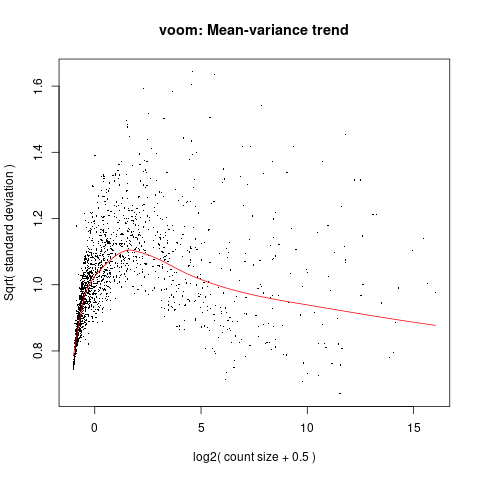

In [8]:
%%R
qcMetadata <- metadataSamplesAllQC # metadataSamplesAllQCAML
qcData <- vbDataBarnDFReconciledQC # vbDataBarnDFReconciledQCAML

# Set up design matrix
covDesignNorm <- model.matrix(~0 + sample_type +
                                  data_submitting_center_label +
                                  platform +
                                  experimental_strategy +
                                  tissue_source_site_label +
                                  portion_is_ffpe,
                              data = qcMetadata)
print(colnames(covDesignNorm))
colnames(covDesignNorm) <- gsub('([[:punct:]])|\\s+','',colnames(covDesignNorm))
print(colnames(covDesignNorm))

# Set up counts matrix
counts <- t(qcData) # DGEList object from a table of counts (rows=features, columns=samples)

# Normalize using edgeR and then plug into voom
dge <- DGEList(counts = counts)
keep <- filterByExpr(dge, covDesignNorm)
dge <- dge[keep,,keep.lib.sizes=FALSE]
print("Now normalizing data...")
dge <- calcNormFactors(dge, method = "TMM")
print("Now applying voom on normalized data...")
vdge <- voom(dge, design = covDesignNorm, plot = TRUE, save.plot = TRUE, normalize.method="none")

In [9]:
%%R

print(table(metadataSamplesAllQCAML$sample_type))


                            Solid Tissue Normal 
                                           1283 
                       Additional - New Primary 
                                             10 
                          Additional Metastatic 
                                              1 
                           Blood Derived Normal 
                                           1866 
                                     Metastatic 
                                            541 
Primary Blood Derived Cancer - Peripheral Blood 
                                            258 
                                  Primary Tumor 
                                          13898 
                                Recurrent Tumor 
                                            118 


In [10]:
%%R

# Apply
bio.var.sample.type <- model.matrix(~sample_type, #sample_type, # histological_diagnosis_label and disease_type tried but cause function to fail
                        data=qcMetadata)
bio.var.gender <- model.matrix(~gender, #sample_type, # histological_diagnosis_label and disease_type tried but cause function to fail
                        data=qcMetadata)
adj.var <- model.matrix(~data_submitting_center_label +
                          platform +
                          experimental_strategy +
                          tissue_source_site_label +
                          portion_is_ffpe,
                        data=qcMetadata)
colnames(bio.var.sample.type) <- gsub('([[:punct:]])|\\s+','',colnames(bio.var.sample.type))
colnames(bio.var.gender) <- gsub('([[:punct:]])|\\s+','',colnames(bio.var.gender))
colnames(adj.var) <- gsub('([[:punct:]])|\\s+','',colnames(adj.var))
print(dim(adj.var))
print(dim(bio.var.sample.type))
print(dim(bio.var.gender))
print(dim(t(vdge$E)))
print(dim(covDesignNorm))

[1] 17625   205
[1] 17625     7
[1] 17625     2
[1] 17625  1795
[1] 17625   211


In [11]:
%%R
snmDataObjSampleTypeWithExpStrategyFA <- snm(raw.dat = vdge$E, 
                                            bio.var = bio.var.sample.type, 
                                            adj.var = adj.var, 
                                            rm.adj=TRUE,
                                            verbose = TRUE,
                                            diagnose = TRUE)
snmDataSampleTypeWithExpStrategyFA <- t(snmDataObjSampleTypeWithExpStrategyFA$norm.dat)

print(dim(snmDataSampleTypeWithExpStrategyFA))

[1] 17625  1795


In [19]:
%%R
save(snmDataSampleTypeWithExpStrategyFA, file = "snmDataSampleTypeWithExpStrategyFA.RData")

# PCA plotting to visually examine batch effects and batch correction

In [13]:
%%R
pcaPlotting <- function(pcaObject,pcChoices, dataLabels, factorString, titleString){
  require(ggbiplot)
  theme_update(plot.title = element_text(hjust = 0.5))
  g <- ggbiplot(pcaObject,pcChoices, obs.scale = 1, var.scale = 1,
                groups = dataLabels, ellipse = TRUE,
                alpha = 0.2,
                circle = TRUE,var.axes=FALSE) + 
    scale_color_nejm(name = factorString) +
    theme_bw() + 
    #theme(legend.direction = "horizontal", legend.position = "top") +
    ggtitle(titleString) + theme(plot.title = element_text(hjust = 0.5))
  
  print(g)
}

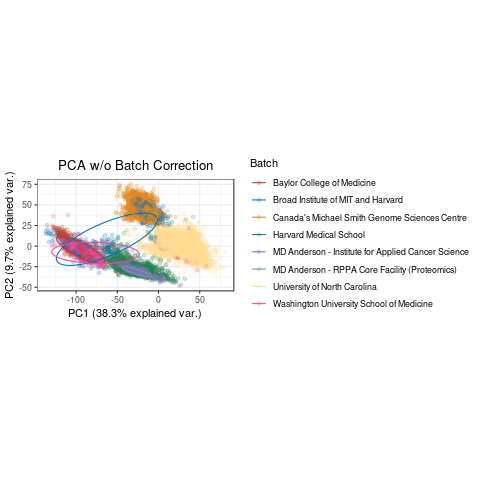

In [14]:
%%R
unnormalizedPCAPlotFA <- pcaPlotting(pcaObject = prcomp(t(vdge$E)),
                                   pcChoices = c(1,2),
                                   dataLabels = qcMetadata$data_submitting_center_label,
                                   factorString = "Batch",
                                   titleString = "PCA w/o Batch Correction")

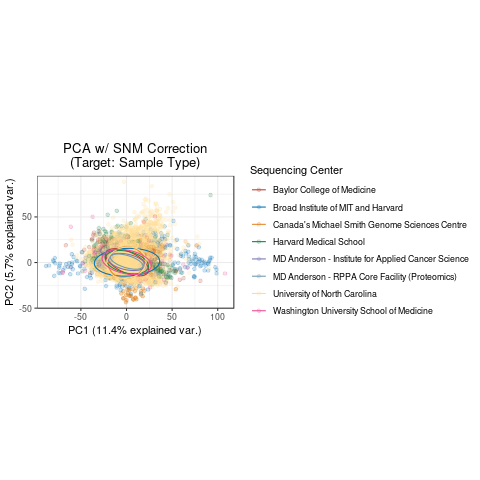

In [15]:
%%R 
snmPCAPlotSampleTypeFA <- pcaPlotting(pcaObject = prcomp(snmDataSampleTypeWithExpStrategyFA),
                          pcChoices = c(1,2),
                          dataLabels = qcMetadata$data_submitting_center_label,
                          factorString = "Sequencing Center",
                          titleString = "PCA w/ SNM Correction\n(Target: Sample Type)")

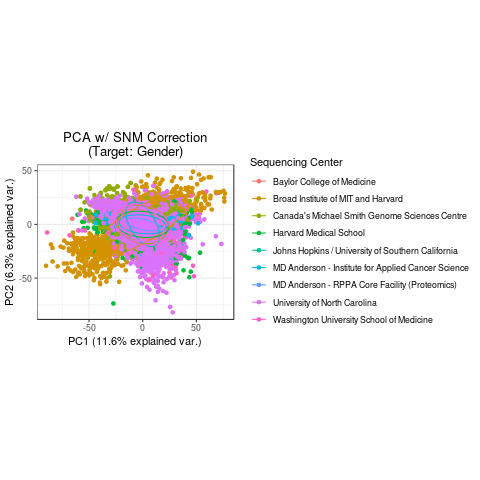

In [57]:
# %%R 
# snmPCAPlotGender <- pcaPlotting(pcaObject = prcomp(snmDataGenderWithAML),
#                           pcChoices = c(1,2),
#                           dataLabels = qcMetadata$data_submitting_center_label,
#                           factorString = "Sequencing Center",
#                           titleString = "PCA w/ SNM Correction\n(Target: Gender)")

In [16]:
%%R
ggsave(plot = unnormalizedPCAPlotFA, 
       filename = "unnormalizedPCAPlotFA_DecreasedOpacity_NEJM.png",
       width = 16.2,
       height = 5.29,
       units = "in",
       dpi = "retina")

ggsave(plot = snmPCAPlotSampleTypeFA, 
       filename = "snmPCAPlotSampleTypeFA_DecreasedOpacity_NEJM.png",
       width = 16.2,
       height = 5.29,
       units = "in",
       dpi = "retina")

# save(snmDataGenderWithAML, metadataSamplesAllQCAML, 
#      vbDataBarnDFReconciledQCAML, 
#      file = "amlVbDataAndMetadataAndSNMByGender.RData")

In [39]:
# %%R
# snmDataObjGenderWithAML <- snm(raw.dat = vdge$E, 
#                                 bio.var = bio.var.gender, 
#                                 adj.var = adj.var, 
#                                 rm.adj=TRUE,
#                                 verbose = TRUE,
#                                 diagnose = TRUE)
# snmDataGenderWithAML <- t(snmDataObjGenderWithAML$norm.dat)

# print(dim(snmDataGenderWithAML))

[1] 17975  1802


# PVCA using key filtered metadata features (i.e. narrowing down the extended version of this)

In [25]:
%%R
# Implement PVCA
# From extended model, remove variables that contribute very little if at all:
# ethnicity, gender, reference_genome
pct_threshold <- 0.8
metaPVCAExtendedFiltered <- metadataSamplesAllQC[,c("sample_type",
                                            "disease_type",
                                            "data_submitting_center_label",
                                            "platform",
                                            "experimental_strategy", 
                                            "tissue_source_site_label",
                                            "portion_is_ffpe")]
print(dim(metaPVCAExtendedFiltered))
print(dim(snmDataSampleTypeWithExpStrategy))
print(dim(vbDataBarnDFReconciledQC))

[1] 17625     7
[1] 17625  1795
[1] 17625  1993


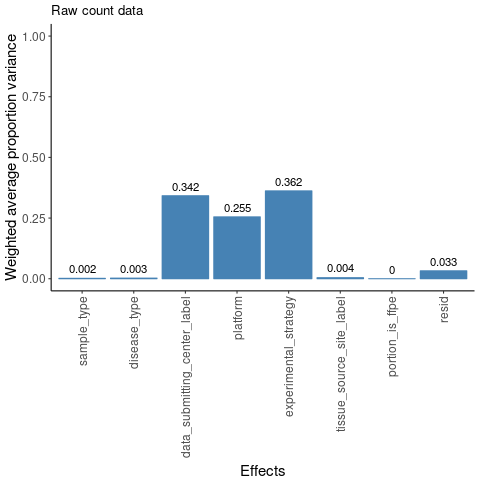

In [26]:
%%R
pvcaVbRawNoVoomNoSNM_ExtendedFiltered_FA <- PVCA(counts = t(vbDataBarnDFReconciledQC), 
                                               meta = metaPVCAExtendedFiltered, 
                                               threshold = pct_threshold,
                                               inter = FALSE)
save(pvcaVbRawNoVoomNoSNM_ExtendedFiltered_FA, file = "pvcaVbRawNoVoomNoSNM_ExtendedFiltered_FA.RData")
PlotPVCA(pvcaVbRawNoVoomNoSNM_ExtendedFiltered_FA, "Raw count data")

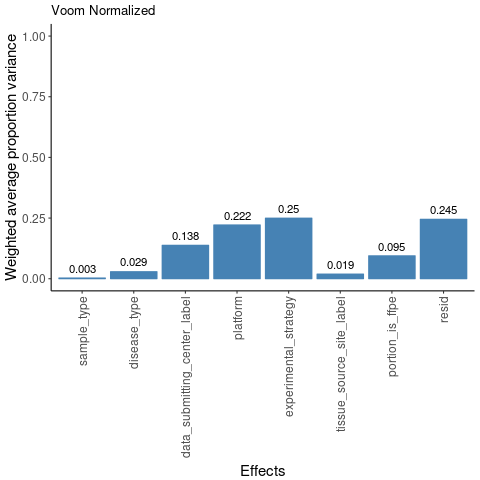

In [27]:
%%R
pvcaVoomNoSNM_ExtendedFiltered_FA <- PVCA(counts = vdge$E,
                                           meta = metaPVCAExtendedFiltered,
                                           threshold = pct_threshold,
                                           inter = FALSE)
save(pvcaVoomNoSNM_ExtendedFiltered_FA, file = "pvcaVoomNoSNM_ExtendedFiltered_FA.RData")
PlotPVCA(pvcaVoomNoSNM_ExtendedFiltered_FA, "Voom Normalized")

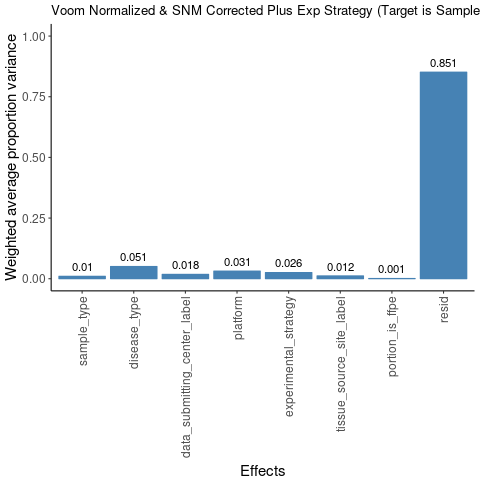

In [28]:
%%R
pvcaSampleWithExpStrategySNM_ExtendedFiltered_FA <- PVCA(counts = t(snmDataSampleTypeWithExpStrategyFA), 
                                                       meta = metaPVCAExtendedFiltered,
                                                       threshold = pct_threshold,
                                                       inter = FALSE)
save(pvcaSampleWithExpStrategySNM_ExtendedFiltered_FA, 
     file = "pvcnoaSampleWithExpStrategySNM_ExtendedFiltered_FA.RData")
PlotPVCA(pvcaSampleWithExpStrategySNM_ExtendedFiltered_FA, 
         "Voom Normalized & SNM Corrected Plus Exp Strategy (Target is Sample Type)")

In [29]:
%%R
1+2

[1] 3


# Examining sample and taxa ratio changes due to batch correction

In [99]:
%%R
require(ggplot2)
require(matrixStats)
divSNMDataSampleType <- snmDataSampleType / t(snmDataObjSampleType$raw.dat)
taxaMedians <- data.frame(Medians = colMedians(divSNMDataSampleType), 
                          Taxa = colnames(divSNMDataSampleType),
                          pval = factor(ifelse(snmDataObjSampleType$pval <=0.05, 
                                               yes = "P-value <= 0.05", no = "P-value > 0.05")))
sampleMedians <- data.frame(Medians = rowMedians(divSNMDataSampleType), 
                            Samples = rownames(divSNMDataSampleType),
                            SeqCenter = metadataSamplesAllQC$data_submitting_center_label,
                            SampleType = metadataSamplesAllQC$sample_type,
                            CancerType = metadataSamplesAllQC$disease_type)
gt <- ggplot(taxaMedians, aes(x = reorder(Taxa, -Medians), y = Medians, fill = pval)) + 
geom_bar(stat = "identity") +
theme(axis.title.x=element_blank(), axis.text.x=element_blank(), axis.ticks.x=element_blank()) +
labs(y = "Median of Normalizing Ratios Per Taxa", x = "Samples", fill = "ANOVA Result Per Taxa") 

gs <- ggplot(sampleMedians, aes(x = reorder(Samples, -Medians), y = Medians, fill = CancerType)) + 
  geom_bar(stat = "identity") + coord_flip() +
  theme(axis.text.y=element_blank(), axis.ticks.y=element_blank()) +
  scale_y_log10() + labs(y = "Median of Normalizing Ratios Per Sample", x = "Samples", fill='Cancer Type') 

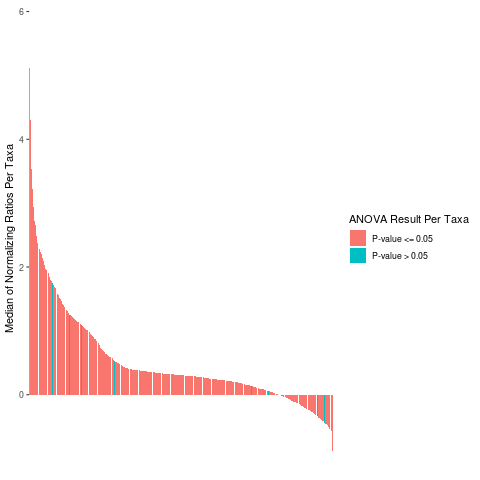

In [100]:
%%R
gt

In [101]:
%%R
ggsave(plot = gt, 
       filename = "snmNormMedianPerTaxaPval.png",
       width = 8.5,
       height = 6,
       units = "in",
       dpi = "retina")

In [24]:
%%R
require(pheatmap)
pheatmap(snmDataSampleTypeLMFit$coefficients,
         clustering_distance_rows = "correlation",
         clustering_distance_cols = "correlation",
         show_rownames = FALSE,
         show_colnames = FALSE,
         filename = "snmLMFitCoefCorr.png")

In [ ]:
# %%R
# save(snmDataObjPathStage, snmDataPathStage, metadataSamplesAllQCPath, file = "snmResultsPathBinned.RData")